# Synthetic data test: Model with multiple sources and moving window scheme

In [1]:
import numpy as np
import harmonica as hm
import verde as vd
import matplotlib.pyplot as plt
import xrft
import euler

## Make a model with multiple sources

Number of data: 22701


/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


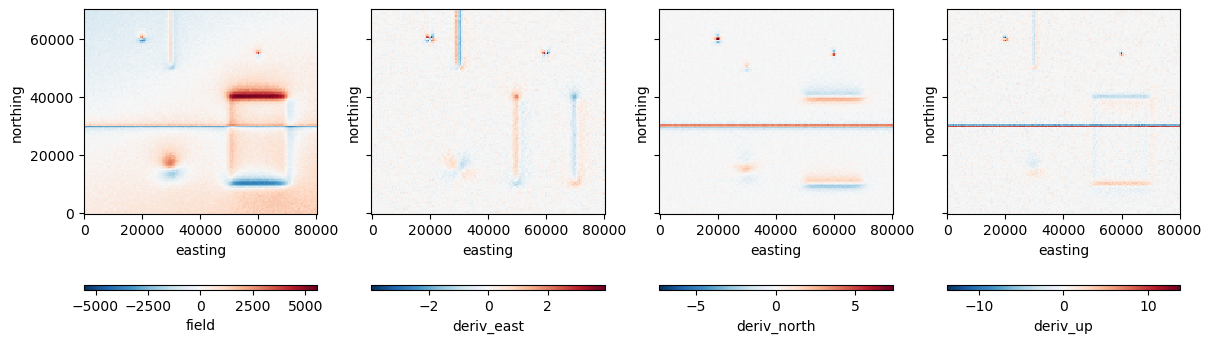

In [2]:
region = [0, 80e3, 0, 70e3]
coordinates = vd.grid_coordinates(region, spacing=500, extra_coords=1000)
inclination, declination = -30, -10
base_level = 500
noise_level = 100
main_field = hm.magnetic_angles_to_vec(1, inclination, declination)

# Dipoles
dipole_coordinates = (30e3, 15e3, -3e3)
magnetic_field = hm.dipole_magnetic(
    coordinates,
    dipoles=dipole_coordinates,
    magnetic_moments=hm.magnetic_angles_to_vec(2e12, inclination, declination),
    field="b",
)
magnetic_anomaly = sum(b * f for b, f in zip(magnetic_field, main_field))
dipole2_coordinates = (20e3, 60e3, 0e3)
magnetic_field = hm.dipole_magnetic(
    coordinates,
    dipoles=dipole2_coordinates,
    magnetic_moments=hm.magnetic_angles_to_vec(5e10, inclination, declination),
    field="b",
)
magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))

# Pipe
size = 50
pipe_coordinates = (60e3, 55e3, 500)
magnetic_field = hm.prism_magnetic(
    coordinates,
    prisms=[
        pipe_coordinates[0] - size,
        pipe_coordinates[0] + size,
        pipe_coordinates[1] - size,
        pipe_coordinates[1] + size,
        pipe_coordinates[2] - 15e3,
        pipe_coordinates[2],
    ],
    magnetization=hm.magnetic_angles_to_vec(2000, -90, 0),
    field="b",
)
magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))

# Dike
dike_coordinates = (30e3, 30e3, 900)
magnetic_field = hm.prism_magnetic(
    coordinates,
    prisms=[
        dike_coordinates[0] - 100e3,
        dike_coordinates[0] + 100e3,
        dike_coordinates[1] - 100,
        dike_coordinates[1] + 100,
        dike_coordinates[2] - 7e3,
        dike_coordinates[2],
    ],
    magnetization=hm.magnetic_angles_to_vec(20, inclination, declination),
    field="b",
)
magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))

# Line
line_coordinates = [30e3, 50e3, 0]
magnetic_field = hm.prism_magnetic(
    coordinates,
    prisms=[
        line_coordinates[0] - 50,
        line_coordinates[0] + 50,
        line_coordinates[1],
        line_coordinates[1] + 100e3,
        line_coordinates[2] - 50,
        line_coordinates[2] + 50,
    ],
    magnetization=hm.magnetic_angles_to_vec(3000, inclination, declination),
    field="b",
)
magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))

# Sill
sill_coordinates = [60e3, 25e3, -0.5e3]
magnetic_field = hm.prism_magnetic(
    coordinates,
    prisms=[
        sill_coordinates[0] - 10e3,
        sill_coordinates[0] + 10e3,
        sill_coordinates[1] - 15e3,
        sill_coordinates[1] + 15e3,
        sill_coordinates[2] - 100,
        sill_coordinates[2] + 100,
    ],
    magnetization=hm.magnetic_angles_to_vec(200, inclination, declination),
    field="b",
)
magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))

# Regional
magnetic_anomaly += 0.01 * coordinates[0] - 0.02 * coordinates[1]

# Add noise and the base level
magnetic_anomaly += np.random.default_rng(42).normal(
    0, noise_level, size=magnetic_anomaly.shape
)
magnetic_anomaly += base_level

print(f"Number of data: {magnetic_anomaly.size}")

# Make a grid and calculate derivatives
# Can't have the height as a coordinate because of a problem with xrft
data = vd.make_xarray_grid(
    coordinates[:2], (magnetic_anomaly, coordinates[-1]), data_names=["field", "height"]
)
data["deriv_east"] = hm.derivative_easting(data.field)
data["deriv_north"] = hm.derivative_northing(data.field)
pad_width = {
    "easting": data.easting.size // 3,
    "northing": data.northing.size // 3,
}
padded = xrft.pad(data.field, pad_width, mode="linear_ramp", constant_values=None)
data["deriv_up"] = xrft.unpad(hm.derivative_upward(padded), pad_width)
# Add back the height
data = data.assign_coords(height=data.height)


fig, axes = plt.subplots(1, 4, figsize=(12, 6), layout="constrained", sharey=True)
for field, ax in zip(["field", "deriv_east", "deriv_north", "deriv_up"], axes.ravel()):
    data[field].plot.pcolormesh(
        ax=ax, cbar_kwargs=dict(orientation="horizontal", aspect=50)
    )
    ax.set_aspect("equal")
plt.show()

## Run Euler Deconvolution and Inversion

In [3]:
window_size = 10e3
window_step = 5e3

In [4]:
%%time
deconvolutions = {}
for si in [1, 2, 3]:
    deconvolutions[si] = euler.EulerDeconvolutionWindowed(
        structural_index=si,
        window_size=window_size,
        window_step=window_step,
        keep=0.15,
    ).fit_grid(data)

CPU times: user 2.36 s, sys: 211 μs, total: 2.36 s
Wall time: 2.72 s


In [5]:
%%time
ei = euler.EulerInversionWindowed(
    window_size=window_size,
    window_step=window_step,
    keep=0.15,
).fit_grid(data)

CPU times: user 188 ms, sys: 94.6 ms, total: 282 ms
Wall time: 3.84 s


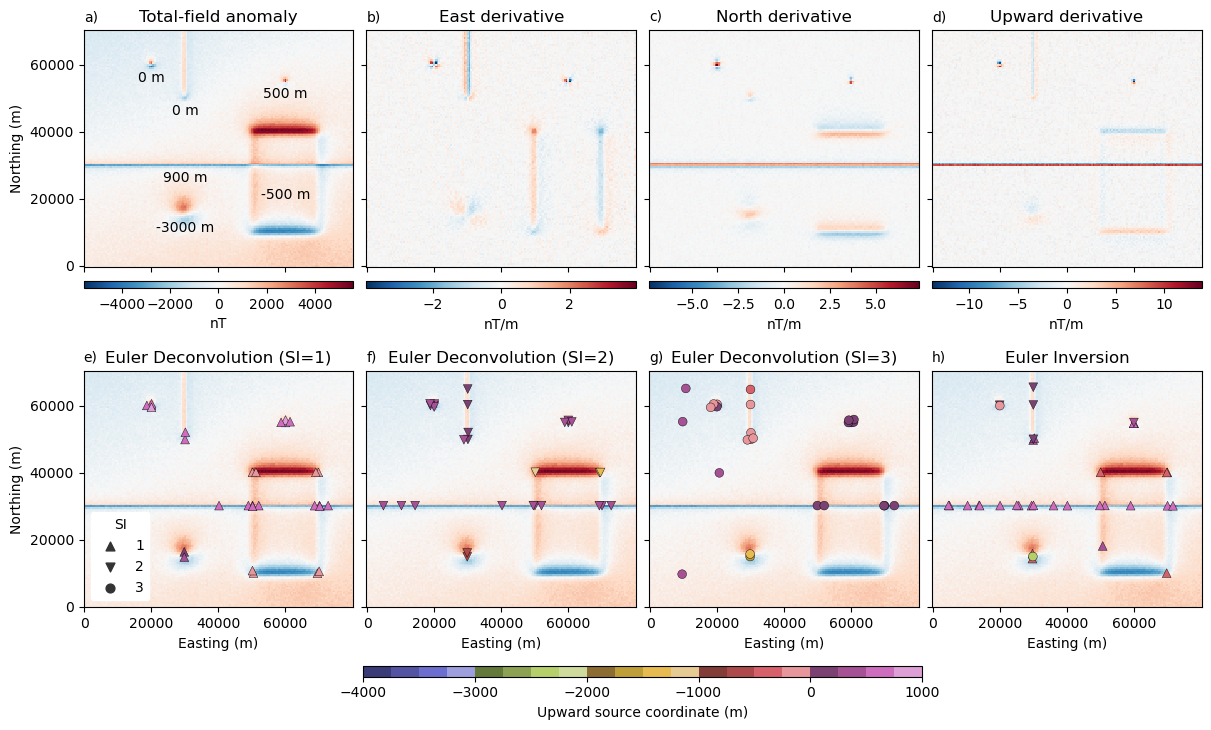

In [6]:
fig, axes = plt.subplots(
    2, 4, figsize=(12, 7.3), layout="constrained", sharey=True, sharex=True
)

subplot_labels = [f"{i})" for i in "abcdefgh"]
units = {"field": "nT", "deriv_east": "nT/m", "deriv_north": "nT/m", "deriv_up": "nT/m"}
data_names = {
    "field": "Total-field anomaly",
    "deriv_east": "East derivative",
    "deriv_north": "North derivative",
    "deriv_up": "Upward derivative",
}
markers = ["^", "v", "o"]
vmin, vmax = -4000, 1000
size = 40
true_sources = [
    dipole_coordinates,
    dipole2_coordinates,
    dike_coordinates,
    sill_coordinates,
    pipe_coordinates,
    line_coordinates,
]

for field, ax in zip(["field", "deriv_east", "deriv_north", "deriv_up"], axes[0, :]):
    ax.set_aspect("equal")
    tmp = data[field].plot.pcolormesh(ax=ax, add_colorbar=False, add_labels=False)
    fig.colorbar(
        tmp, ax=ax, orientation="horizontal", aspect=40, pad=0.02, label=units[field]
    )
    ax.set_title(data_names[field])
ax = axes[0, 0]
for source in true_sources:
    ax.text(
        source[0], source[1] - 5e3, f"{source[2]:.0f} m", horizontalalignment="center"
    )
for ax in axes[1, :]:
    ax.set_aspect("equal")
    data.field.plot.pcolormesh(ax=ax, add_colorbar=False, add_labels=False)

# Euler deconvolution
for si, marker, ax in zip([1, 2, 3], markers, axes[1, :-1]):
    ax.set_title(f"Euler Deconvolution (SI={si})")
    ax.scatter(
        *deconvolutions[si].locations_[:2],
        c=deconvolutions[si].locations_[2],
        s=size,
        marker=marker,
        vmin=vmin,
        vmax=vmax,
        edgecolors="black",
        linewidths=0.3,
        cmap="tab20b",
    )
# Euler inversion
labels = {}
ax = axes[1, -1]
ax.set_title("Euler Inversion")
for si, marker in zip([1, 2, 3], markers):
    is_si = ei.structural_indices_ == si
    tmp = ax.scatter(
        *ei.locations_[:2, is_si],
        c=ei.locations_[2, is_si],
        s=size,
        marker=marker,
        vmin=vmin,
        vmax=vmax,
        edgecolors="black",
        linewidths=0.3,
        cmap="tab20b",
    )
    labels[si] = ax.scatter([], [], c="#333333", s=size, marker=marker)

axes[1, 0].legend(
    [labels[si] for si in sorted(labels)],
    sorted(labels),
    loc="lower left",
    framealpha=1,
    facecolor="#ffffff",
    edgecolor="#ffffff",
    title="SI",
)
fig.colorbar(
    tmp,
    ax=axes[1, :],
    aspect=50,
    pad=0.05,
    shrink=0.5,
    orientation="horizontal",
    label="Upward source coordinate (m)",
)

for ax, label in zip(axes.ravel(), subplot_labels):
    ax.text(0, 1.04, label, transform=ax.transAxes)
for ax in axes[1, :]:
    ax.set_xticks(np.arange(0, 61e3, 20e3))
for ax in axes[:, 0]:
    ax.set_yticks(np.arange(0, 61e3, 20e3))
for ax in axes[:, 0]:
    ax.set_ylabel("Northing (m)")
for ax in axes[1, :]:
    ax.set_xlabel("Easting (m)")

for dpi, res in zip([70, 300], ["", "-highres"]):
    fig.savefig(
        f"../paper/figures/synthetic-windows{res}.png", dpi=dpi, bbox_inches="tight"
    )

plt.show()